# Heat equation

## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib import animation
from IPython.display import HTML
from scipy import special
import math

## initialization

In [2]:
COURANT = 0.003
LAMBDA_0 = 0.1
SIGMA = 0.8

X_max = 15
T_max = 30
X_min = T_min = 0
U_0 = 25
THETA = 0.2

NUMBER_X = 100
NUMBER_T = math.ceil(LAMBDA_0 * (T_max - T_min) * (U_0**SIGMA) * T_max * NUMBER_X*2 / 
                    (X_max - X_min)**2 / COURANT) 

C = np.sqrt((U_0**SIGMA) * LAMBDA_0 / SIGMA)

In [4]:
NUMBER_T

350204

In [5]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
T_RANGE = np.linspace(T_min, T_max, NUMBER_T)

X_STEP = X_RANGE[1] - X_RANGE[0]
T_STEP = T_RANGE[1] - T_RANGE[0]

In [6]:
X, T = np.meshgrid(X_RANGE, T_RANGE, indexing='ij')

# Boundary / initial conditions
U = np.zeros_like(X)
U[:, 0] = 0
U[0, :] = U_0 * (T ** (1/SIGMA))[0, :]
U[-1, :] = 0

U_EXACT = U.copy()

In [7]:
alpha = np.zeros_like(X_RANGE)
beta = np.zeros_like(X_RANGE)

alpha[1] = 0

In [8]:
def calc_lambda(u):
    return LAMBDA_0 * (u ** SIGMA)

def calc_lambda_plus(L):
    L_plus = np.roll(L, -1)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = 2 * L * L_plus / (L + L_plus)
    mask = np.abs(L + L_plus) < 0.1
    result[mask] = ((L + L_plus) / 2)[mask]
    return result
    
def calc_lambda_minus(L):
    L_minus = np.roll(L, +1)
    with np.errstate(divide='ignore', invalid='ignore'):
        result = 2 * L * L_minus / (L + L_minus)
    mask = np.abs(L + L_minus) < 0.1
    result[mask] = ((L + L_minus) / 2)[mask]
    return result

def calculate_coefficients(u, L, t):
    beta[1] = U_0 * (t ** (1/SIGMA))
    
    l_minus = calc_lambda_minus(L)
    l_plus = calc_lambda_plus(L)
    
    a = THETA * T_STEP * l_minus / (X_STEP**2)
    b = THETA * T_STEP * l_plus / (X_STEP**2)
    c = a + b + 1
    d = u + T_STEP * (1 - THETA) / (X_STEP**2) * (np.roll(u, -1) * l_plus -
                                                  u * (l_plus + l_minus) +
                                                  np.roll(u, 1) * l_minus)
    for i in range(1, len(u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
    

    return alpha, beta

def calculate_exact_solution(x, t):
    result = np.zeros_like(x)
    mask = C * t > x 
    x = x[mask]
    t = t[mask]
    
    temp = C * SIGMA * (C * t - x) / LAMBDA_0
    result[mask] = np.power(temp, 1./SIGMA)
    return result

## main procedure

In [9]:
for j in tqdm_notebook(list(range(0, NUMBER_T - 1))):
    current_u = U[:, j]
    lambda_array = calc_lambda(current_u)
    
    alpha, beta = calculate_coefficients(current_u, lambda_array, T_RANGE[j])
    
    for i in reversed(range(0, NUMBER_X-1)):
        U[i, j+1] = alpha[i+1] * U[i+1, j+1] + beta[i+1]

In [47]:
U_EXACT = calculate_exact_solution(X, T)

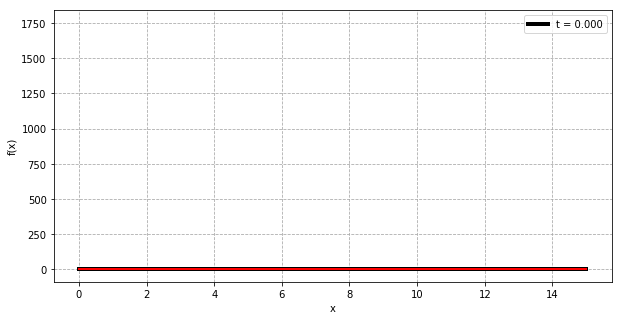

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

l1, = ax.plot(X_RANGE, U[:,-1], lw=4, color='black', label=None)
l2, = ax.plot(X_RANGE, U_EXACT[:,-1], lw=2, color='red', label=None)

ax.grid(c='#aaaaaa', ls='--')

ax.set_ylabel("f(x)")
ax.set_xlabel("x")

def animate(i):
    l1.set_data(X_RANGE, U[:, i])
    l1.set_label('t = ' + '%.3f' %(i * T_STEP))
    l2.set_data(X_RANGE, U_EXACT[:, i])

    legend = plt.legend(loc='upper right')
    return l1, l2, legend

ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, NUMBER_T - 2, 50).astype(int), interval=50)

#ani.save("solution.mp4")
HTML(ani.to_jshtml())